In [13]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import json
from sklearn.model_selection import KFold
from collections import defaultdict
import matplotlib.pyplot as plt
import shap

import sys
sys.path.append("..")
sys.path.append("../../../qtrees-ai-data-private")

from qtreesprivate.preprocessed_data import Preprocessor, Data_loader

from qtrees.helper import get_logger, init_db_args
from qtrees.constants import NOWCAST_FEATURES, FORECAST_FEATURES

from qtreesprivate.plots_util import apply_qtrees_style
import matplotlib.style as style
style.use("../../../qtrees-ai-data-private/data/baumblick.mplstyle")

pd.set_option('display.max_columns', None)
DEPTH_MAP = {1: "30 cm", 2: "60 cm", 3: "90 cm"}

CAT_FEATURES = ["baumscheibe_surface", "gattung", "month", "baumscheibe_cat", "standalter_cat"]
NUM_FEATURES = ["water_sga","water_gdk", "shading_index", "wind_max_ms", "rainfall_mm", "temp_avg_c", "ghi_sum_whm2", "gestern", "upm"]

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
weather_station = pd.read_sql("SELECT date,wind_max_ms,wind_avg_ms,rainfall_mm,temp_max_c,temp_avg_c,upm FROM public.weather", con=engine.connect())

In [33]:
weather_solar = pd.read_sql("SELECT *FROM private.weather_tile_measurement", con=engine.connect())

In [36]:
weather_solar.min()

tile_id                  2
date            2021-06-01
ghi_max_wm2           42.0
dni_max_wm2            0.0
dhi_max_wm2           42.0
ghi_sum_whm2         189.0
dni_sum_whm2           0.0
dhi_sum_whm2         189.0
wind_avg_ms       0.833333
wind_max_ms            2.0
temp_avg_c           -8.25
temp_max_c            -5.0
rainfall_mm            0.0
dtype: object

In [37]:
weather_station.min()

date           2022-03-22
wind_max_ms           3.2
wind_avg_ms           0.9
rainfall_mm           0.0
temp_max_c           -4.3
temp_avg_c           -6.8
upm                 34.46
dtype: object

In [31]:
weather_station[weather_station.rainfall_mm.isna()]

,date,wind_max_ms,wind_avg_ms,rainfall_mm,temp_max_c,temp_avg_c,upm
427,2023-05-23,12.9,4.5,NaN,21.4,15.3,72.96
451,2023-06-16,11.1,3.5,NaN,21.2,16.0,84.29
452,2023-06-17,7.2,2.2,NaN,21.7,17.0,79.75
454,2023-06-19,8.2,2.7,NaN,29.2,22.8,59.75
455,2023-06-20,8.7,1.8,NaN,26.4,21.9,76.21
545,2023-09-18,9.3,3.4,NaN,26.3,21.0,71.71
549,2023-09-22,8.2,2.6,NaN,19.0,16.8,85.54


In [30]:
weather_station[weather_station.wind_max_ms.isna()]

,date,wind_max_ms,wind_avg_ms,rainfall_mm,temp_max_c,temp_avg_c,upm
160,2022-08-29,NaN,NaN,0.0,23.5,16.8,NaN
161,2022-08-30,NaN,NaN,0.0,23.0,17.5,NaN
162,2022-08-31,NaN,NaN,0.0,22.9,17.9,NaN
163,2022-09-01,NaN,NaN,0.0,23.0,17.1,NaN
174,2022-09-12,NaN,NaN,0.0,21.0,15.5,NaN
377,2023-04-03,NaN,NaN,0.0,5.7,1.8,NaN
511,2023-08-15,NaN,2.6,0.0,31.2,24.4,76.04
534,2023-09-07,NaN,2.8,0.0,29.3,21.8,60.42


In [14]:
# dev
user = "postgres"
postgres_passwd = "To4dXsZv2g_tbu*2_iDW"
db_qtrees = "qtreesdev-iac-rds.ct3edyn2bzjb.eu-central-1.rds.amazonaws.com"

engine = create_engine(
    f"postgresql://{user}:{postgres_passwd}@{db_qtrees}:5432/qtrees"
)

loader = Data_loader(engine)
data = loader.download_data(with_sensors=True)
prep = Preprocessor()
prep.fit(data)
X = prep.transform(data)

#X.to_pickle("data.p")

X, y = X.drop(columns="value"), X["value"]

tree_devices = pd.read_sql(con= engine, sql="SELECT * FROM private.tree_devices")
#tree_devices.to_pickle("tree_devices.p")

0 trees processed
100000 trees processed
200000 trees processed
300000 trees processed
400000 trees processed


In [20]:
X.water_gdk

type_id  tree_id            timestamp                
1        00008100:000bbb14  2021-06-01 00:00:00+00:00   NaN
                            2021-06-02 00:00:00+00:00   NaN
                            2021-06-03 00:00:00+00:00   NaN
                            2021-06-04 00:00:00+00:00   NaN
                            2021-06-05 00:00:00+00:00   NaN
                                                         ..
3        00008100:0024bc84  2023-09-23 00:00:00+00:00   NaN
         00008100:002268c0  2023-09-23 00:00:00+00:00   NaN
         00008100:0024ba50  2023-09-23 00:00:00+00:00   NaN
         00008100:0024c2fe  2023-09-23 00:00:00+00:00   NaN
         00008100:0024c304  2023-09-23 00:00:00+00:00   NaN
Name: water_gdk, Length: 56212, dtype: float64

In [8]:
X.shape, y.shape

# - find water_gdk/water_sga
# - where are the NaNs coming from?

((56212, 17), (56212,))

In [18]:
X.columns

Index(['month', 'baumscheibe_m2', 'baumscheibe_surface', 'gattung',
       'standalter', 'water_gdk', 'water_sga', 'shading_index', 'wind_max_ms',
       'wind_avg_ms', 'rainfall_mm', 'temp_max_c', 'temp_avg_c', 'upm',
       'mean_yesterday', 'shift_1', 'shift_7'],
      dtype='object')

In [16]:
X.describe()

,water_gdk,water_sga,shading_index,wind_max_ms,wind_avg_ms,rainfall_mm,temp_max_c,temp_avg_c,upm,mean_yesterday,shift_1,shift_7
count,0.0,0.0,31417.000000,24990.000000,24990.000000,24990.000000,24990.000000,24990.000000,24990.000000,38320.000000,33028.000000,31793.000000
mean,NaN,NaN,0.615477,10.274090,3.397780,10.634330,22.979045,17.519227,63.083087,40.076912,39.087753,38.815448
std,NaN,NaN,0.185324,1.583537,0.647889,11.198544,5.049277,4.564161,8.931889,18.871253,34.132922,33.969186
min,NaN,NaN,0.223619,7.416327,2.204082,0.000000,9.171429,5.216327,44.707347,0.000000,0.000000,0.000000
25%,NaN,NaN,0.443791,9.102041,2.879592,2.585714,20.171429,14.730612,56.403061,24.709124,15.710356,15.670090
50%,NaN,NaN,0.606714,9.993878,3.395918,7.628571,23.865306,18.544898,62.887755,38.998177,25.926640,25.782465
75%,NaN,NaN,0.762441,11.279592,3.793878,15.085714,26.844898,20.865306,70.060816,52.852314,52.910047,52.367700
max,NaN,NaN,1.000000,15.620408,5.618367,58.785714,30.424490,24.144898,82.137143,109.039320,198.664060,198.664060


In [181]:
def pick_test_weeks(weeks, n_train_weeks=5, n_test_weeks=4):
    train_weeks, test_weeks = [], []

    i = 0
    while i + n_train_weeks  < len(weeks):
        # Define the training period
        train_start = weeks[i]
        train_end = weeks[i + min(n_train_weeks, len(weeks) - i) - 1]

        # Define the testing period
        test_start = weeks[i + n_train_weeks]
        if i + n_train_weeks + n_test_weeks < len(weeks):
            test_end = weeks[i + n_train_weeks + n_test_weeks -1]
        else:
            test_end = weeks[-1]
        
        train_weeks.extend(range(train_start, train_end + 1))  
        test_weeks.extend(range(test_start, test_end + 1)) 

        i = i + n_train_weeks + n_test_weeks 

    return train_weeks, test_weeks

def create_train_test_split_across_sites(data, n_splits=4):
    train_data_folds, test_data_folds = [], []

    # Create a KFold object
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    site_ids = data.site_id.unique()

    for train_index, test_index in kf.split(site_ids):
        train_data = data[data.site_id.isin(site_ids[train_index])]
        test_data = data[data.site_id.isin(site_ids[test_index])]

        # calculate the feature across only the train data and use it also for testing
        temp = train_data.groupby(["timestamp","type_id"])["value"].mean().shift(1).rename("gestern")
        train_data = train_data.merge(temp, left_on=["timestamp", "type_id"], right_index=True)
        test_data = test_data.merge(temp, left_on=["timestamp", "type_id"], right_index=True)

        train_data_folds.append(train_data.dropna())
        test_data_folds.append(test_data.dropna())

    return list(zip(train_data_folds, test_data_folds))


def log_experiment_results(fold_results, experiment_id="experiment1", model="RandomForestRegressor", features=[], hyper_parameters={}, csv_file="experiments.csv"):
    df = pd.DataFrame([{"experiment_id": experiment_id, 
                        "Mean 30cm": json.dumps({key: np.round(np.mean([d[key] for d in fold_results["Folds 30cm"]]),2) for key in fold_results["Folds 30cm"][0]}),
                        "Mean 60cm": json.dumps({key: np.round(np.mean([d[key] for d in fold_results["Folds 60cm"]]),2) for key in fold_results["Folds 60cm"][0]}),
                        "Mean 90cm": json.dumps({key: np.round(np.mean([d[key] for d in fold_results["Folds 90cm"]]),2) for key in fold_results["Folds 90cm"][0]}),
                        "Folds 30cm": json.dumps(fold_results["Folds 30cm"]), 
                        "Folds 60cm": json.dumps(fold_results["Folds 60cm"]), 
                        "Folds 90cm": json.dumps(fold_results["Folds 90cm"]), 
                        "model": model, "features": json.dumps(features), 
                        "hyper_parameters": json.dumps(hyper_parameters)}])

    # Check if the file already exists; if not, write the header
    write_header = not pd.io.common.file_exists(csv_file)

    with open(csv_file, 'a', newline='') as file:
        df.to_csv(file, mode='a', index=False, header=write_header)


def read_experiment_log(csv_file):
    data = pd.read_csv(csv_file)
    data['hyper_parameters'] = data['hyper_parameters'].apply(json.loads)
    data['features'] = data['features'].apply(json.loads)
    return data

def predict_depth(model, test_data, type_id = 1, features=[]):
    X_test, y_test = test_data.loc[test_data.type_id==type_id, features], test_data.loc[test_data.type_id==type_id,["value"]]
    
    y_hat =  model.predict(X_test) # y_hat = np.expm1(model.predict(X_test))
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    mae = mean_absolute_error(y_test, y_hat)

    y_test.rename(columns={"value": "y_test"})
    y_test["y_hat"] = y_hat
    y_test["tree_id"] = test_data.loc[test_data.type_id==type_id, "tree_id"]
    y_test["timestamp"] = test_data.loc[test_data.type_id==type_id, "timestamp"]
    y_test["benchmark"] = test_data.loc[test_data.type_id==type_id, "gestern"]

    #print(f"Random Forest: Tiefe {DEPTH_MAP[type_id]}: RMSE {rmse:.2f}, MAE {mae:.2f}")
    return {"rmse": round(rmse, 2), "mae": round(mae, 2)}, y_test


def predict_benchmark(test_data, type_id = 1, features=[]):
    _, y_test = test_data.loc[test_data.type_id==type_id, features], test_data.loc[test_data.type_id==type_id, "value"]
    y_hat_benchmark = test_data.loc[test_data.type_id==type_id, "gestern"]
    rmse = mean_squared_error(y_test, y_hat_benchmark, squared=False)
    mae = mean_absolute_error(y_test, y_hat_benchmark)
    return {"rmse": round(rmse, 2), "mae": round(mae, 2)}

def evaluate_benchmark_on_folds(folds, log_experiment=True):
    fold_results = defaultdict(list)
    for fold in folds:
        fold_results["Folds 30cm"].append(predict_benchmark(fold[1], type_id=1))
        fold_results["Folds 60cm"].append(predict_benchmark(fold[1], type_id=2))
        fold_results["Folds 90cm"].append(predict_benchmark(fold[1], type_id=3))

    if log_experiment:
        log_experiment_results(fold_results, experiment_id="Benchmark", model="Benchmark", features=[], hyper_parameters={})
        
    return fold_results

def init_result_folder(name):
    folder_path = os.path.join(".", name)  # Use "." to create the folder in the current directory

    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                os.rmdir(file_path)
    else:
        os.makedirs(folder_path)

    return folder_path

def plot_predictions(predictions, path):
    y_min, y_max = 0.0, predictions.value.max()
    min_date, max_date = predictions.timestamp.min(), predictions.timestamp.max()
    idx = pd.DatetimeIndex(pd.date_range(start=min_date, end=max_date, freq='D'))

    for tree in predictions.tree_id.unique():
        plot_data = predictions[(predictions.tree_id==tree) & (predictions.type_id==1)].set_index("timestamp").sort_index()
        
        if len(plot_data) > 0:
            mae_forecast = mean_absolute_error(plot_data["value"], plot_data["y_hat"])
            mae_benchmark = mean_absolute_error(plot_data["value"], plot_data["benchmark"])
            plot_data = plot_data.reindex(idx)
            
            fig, ax = plt.subplots(1,2, figsize=(12,5))
            plot_data.value.plot(ax=ax[0], label="Sensorwert")
            plot_data.y_hat.plot(ax=ax[0], label="Vorhersage")
            plot_data.benchmark.plot(ax=ax[0], label="Benchmark")
            ax[0].set_ylim((y_min, y_max))
            ax[0].set_xlim(("2022-04", "2022-09"))
            ax[0].xaxis.grid(False)

            plot_data.value.plot(ax=ax[1], label="Sensorwert")
            plot_data.y_hat.plot(ax=ax[1], label="Vorhersage")
            plot_data.benchmark.plot(ax=ax[1], label="Benchmark")
            ax[1].set_ylim((y_min, y_max))
            ax[1].set_xlim(("2023-04", "2023-09"))
            #ax[1].legend()
            ax[1].xaxis.grid(False)

            apply_qtrees_style(fig,f"Tree {tree}, Tiefe 30cm",f"Vorhersage MAE: {mae_forecast:.2f}, Benchmark MAE: {mae_benchmark:.2f}")
            ax[0].get_legend().set_visible(False)
        
        plt.savefig(os.path.join(path, f"forecast_{tree}.png"), bbox_inches="tight")

def evaluate_folds(folds, name, model, hyper_parameters, features, explain_model=False, log_experiment=True):
    fold_results = defaultdict(list)

    predictions = []

    path = init_result_folder(name)

    for idx, fold in enumerate(folds):
        X_train, y_train = fold[0][features], fold[0]["value"]
        model.fit(X_train, y_train)

        results, predictions30 = predict_depth(model, fold[1], type_id=1, features=features)
        fold_results["Folds 30cm"].append(results)
        predictions30["type_id"] = 1
        results, predictions60 = predict_depth(model, fold[1], type_id=2, features=features)
        fold_results["Folds 60cm"].append(results)
        predictions60["type_id"] = 2
        results, predictions90 = predict_depth(model, fold[1], type_id=2, features=features)
        fold_results["Folds 90cm"].append(results)
        predictions90["type_id"] = 3

        fold_predictions = pd.concat([predictions30, predictions60, predictions90], ignore_index=True)
        fold_predictions["fold"] = idx
        predictions.append(fold_predictions)
    
        if explain_model:
            feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
            feature_importance_df.to_csv(os.path.join(path, f"feature_importance_fold_{idx}.csv"))
            feature_importance_df.set_index("Feature").plot(kind="barh");
            plt.savefig(os.path.join(path, f"feature_importance_fold_{idx}.png"), bbox_inches="tight")

            explainer = shap.Explainer(model, X_train)
            shap_values = explainer(X_train)
            shap.plots.bar(shap_values)
            plt.savefig(os.path.join(path, f"shap_values_{idx}.png"), bbox_inches="tight")

            shap.plots.violin(shap_values)
            plt.savefig(os.path.join(path, f"shap_values_violin_{idx}.png"), bbox_inches="tight")


    if log_experiment:
        log_experiment_results(fold_results, experiment_id=name, model=model.__class__.__name__, features=features, hyper_parameters=hyper_parameters)
        
    total_predictions = pd.concat(predictions, ignore_index=True)
    total_predictions.to_csv(os.path.join(path, f"predictions_fold_{idx}.csv"))

    plot_predictions(total_predictions, path)

    return fold_results, total_predictions

In [182]:
data = pd.read_pickle("data.p")
data["water"] = data["water_gdk"] + data["water_sga"]

tree_devices = pd.read_pickle("tree_devices.p")

FEATURES_POC = ["type_id", "standalter_cat", "shading_index", "temp_avg_c", "rainfall_mm", "water_sga", "water_gdk", "month", "gestern"] #, "standalter_cat", "shading_index", 
FEATURES_MVP = ["type_id", "shading_index", "standalter_cat", "temp_avg_c", "rainfall_mm",  "water_sga", "water_gdk", "month", "gestern", "baumscheibe_surface", "gattung", "baumscheibe_cat", "wind_max_ms", "ghi_sum_whm2", "upm"]
FEATURE_NAIVE = ["gestern"]

data = data.loc[(data.timestamp >= "2022-1")&(data.timestamp < "2023-09"), :].sort_values(["sensor_id", "timestamp"]).dropna(subset=["value"])
weather_features = ["temp_avg_c", "rainfall_mm", "wind_max_ms", "ghi_sum_whm2", "upm"]
for c in weather_features:
    data[c] = data[c].interpolate()

clean_idx = data.loc[data.timestamp < "2023-09", FEATURES_MVP].dropna().index
data = data.loc[clean_idx]
data = data.merge(tree_devices[["tree_id", "site_id"]], how="left", left_on="tree_id", right_on="tree_id")
data = data.drop("gestern", axis=1)

#create categories
CAT_FEATURES = ["baumscheibe_surface", "gattung", "month", "baumscheibe_cat", "standalter_cat"]
for c in [x for x in FEATURES_MVP if x in CAT_FEATURES]:
    data.loc[:, c] = data.loc[:, c].factorize()[0].astype(int)

#for c in [x for x in FEATURES_MVP if x in NUM_FEATURES]:
#    clean_data.loc[:,c] = (clean_data.loc[:,c]-clean_data.loc[:,c].mean())/clean_data.loc[:,c].std()
data.gattung = data.gattung.astype(int)
data.baumscheibe_surface = data.baumscheibe_surface.astype(int)
data.shape

(21854, 26)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


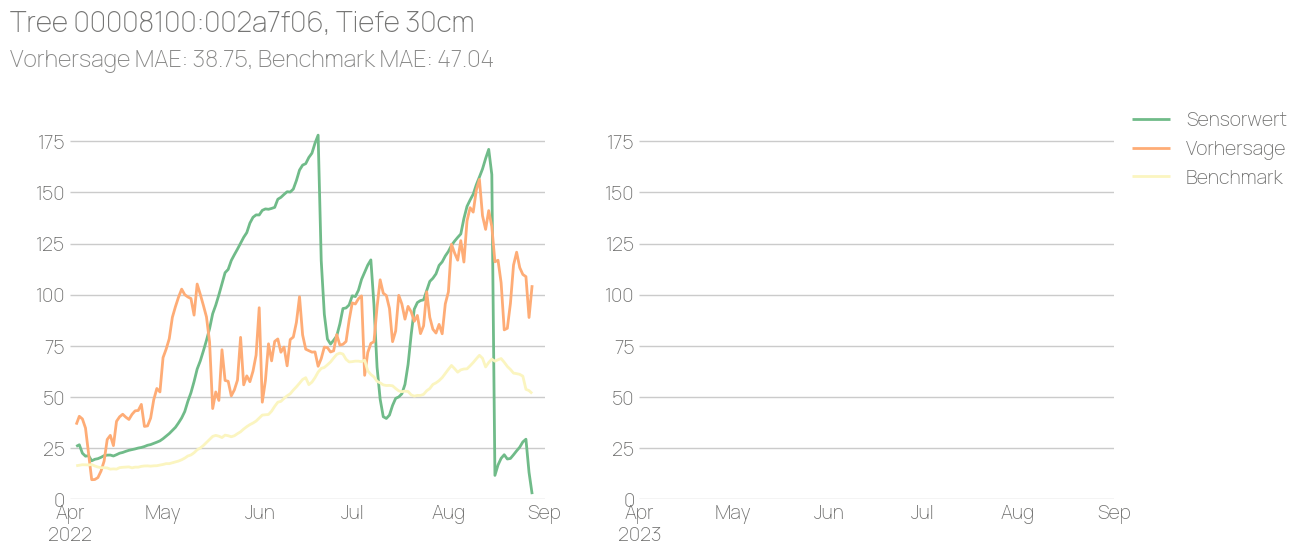

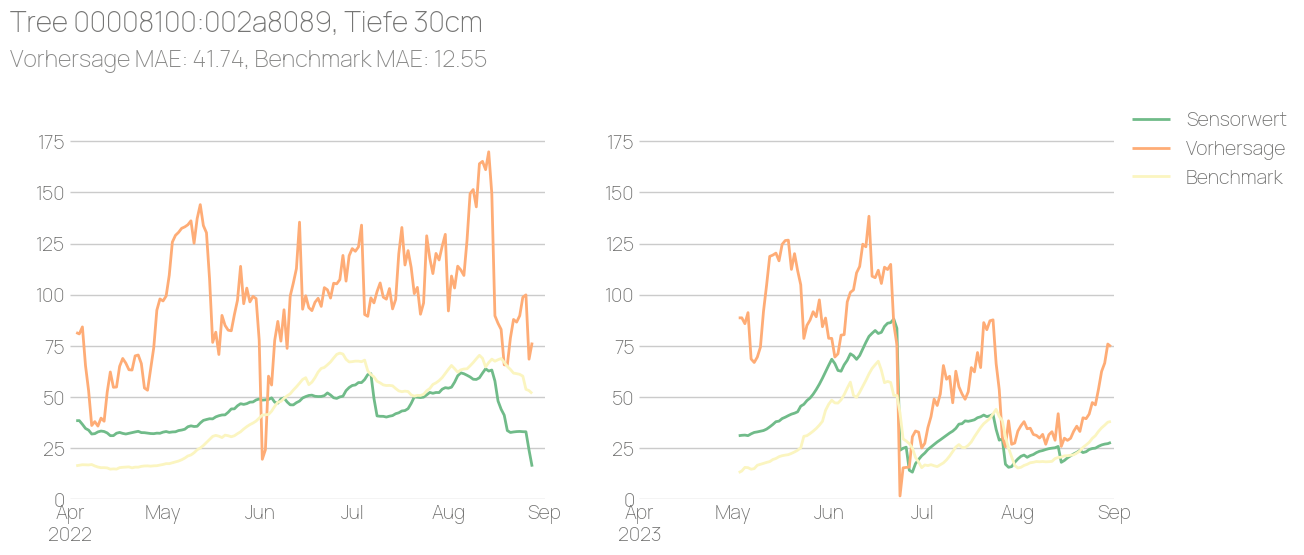

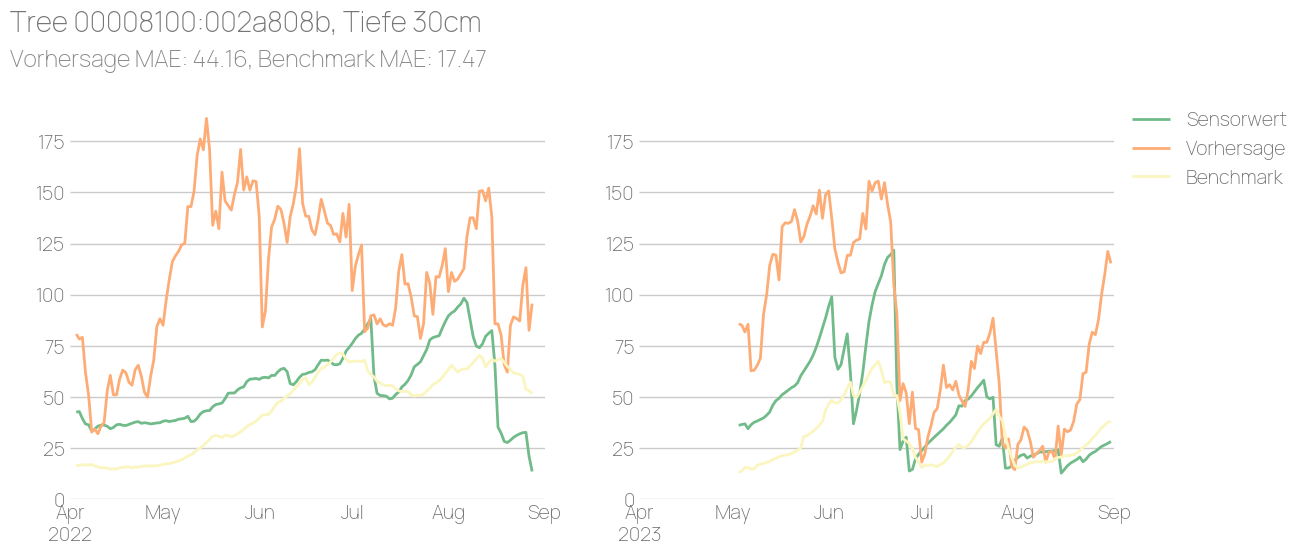

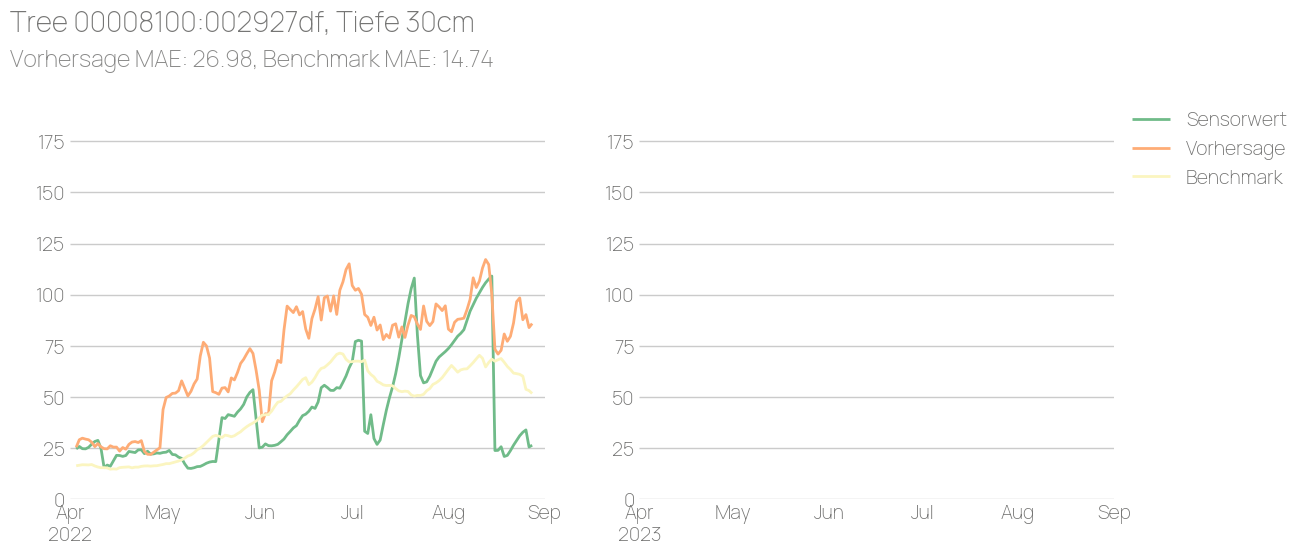

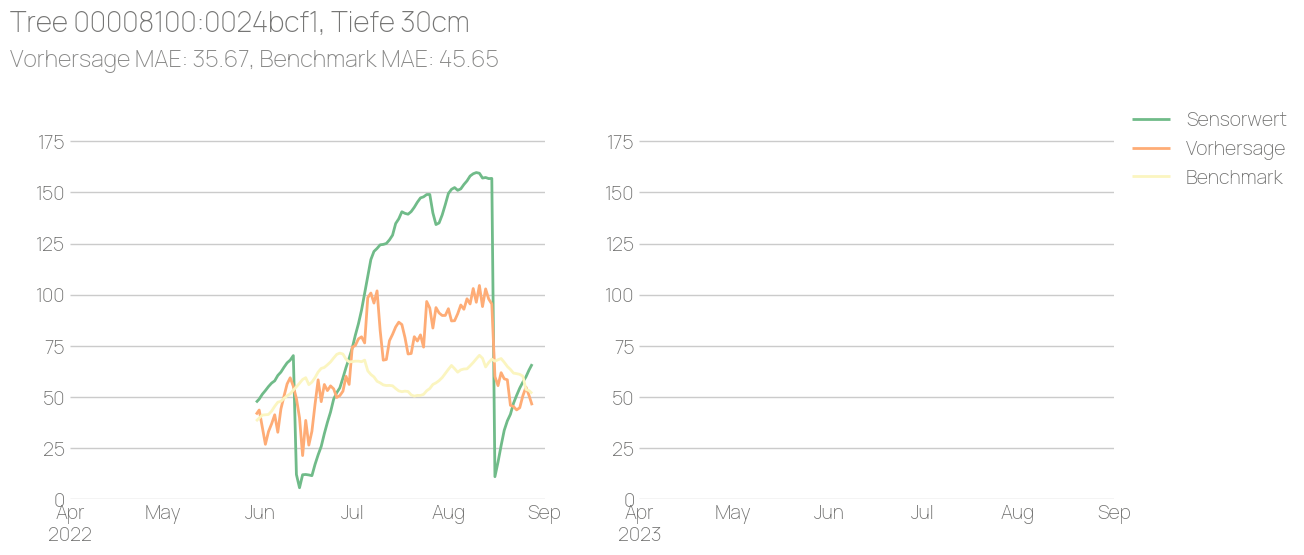

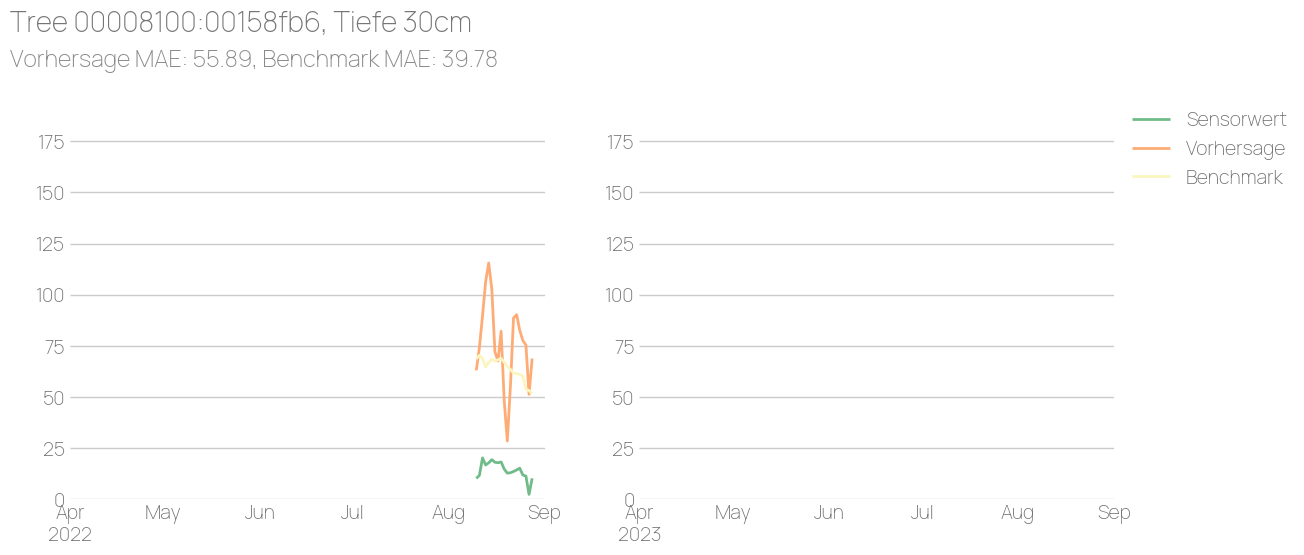

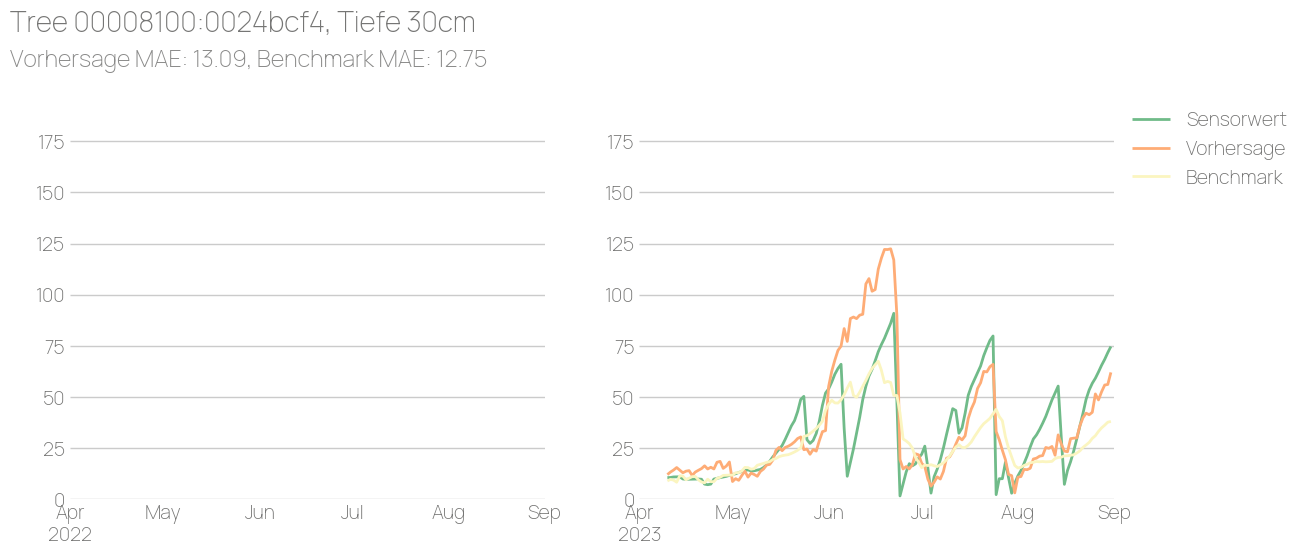

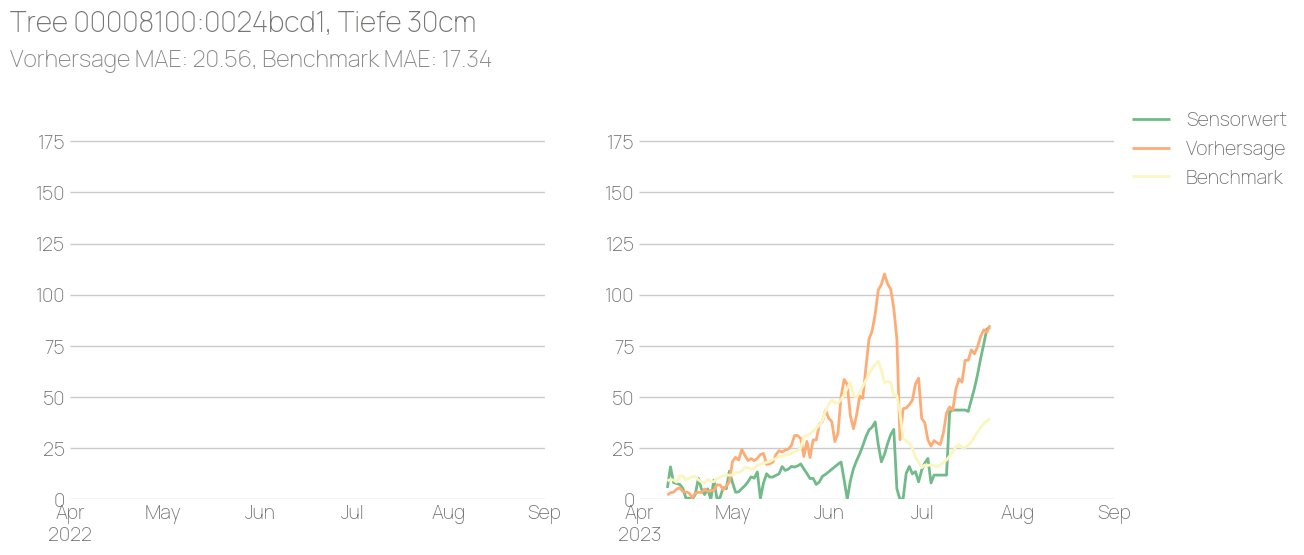

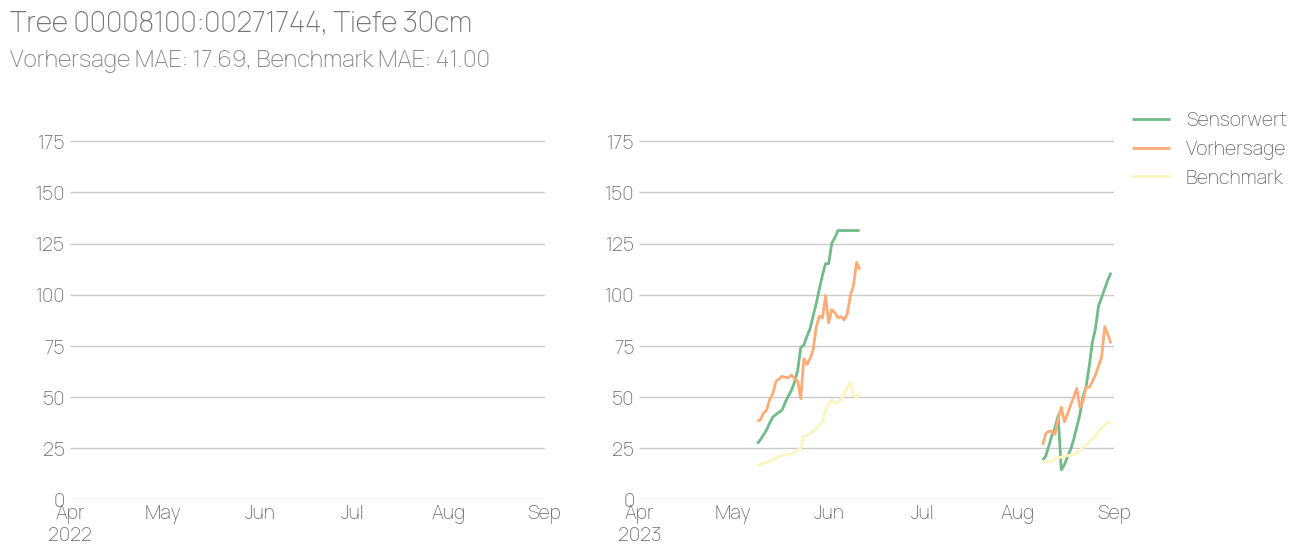

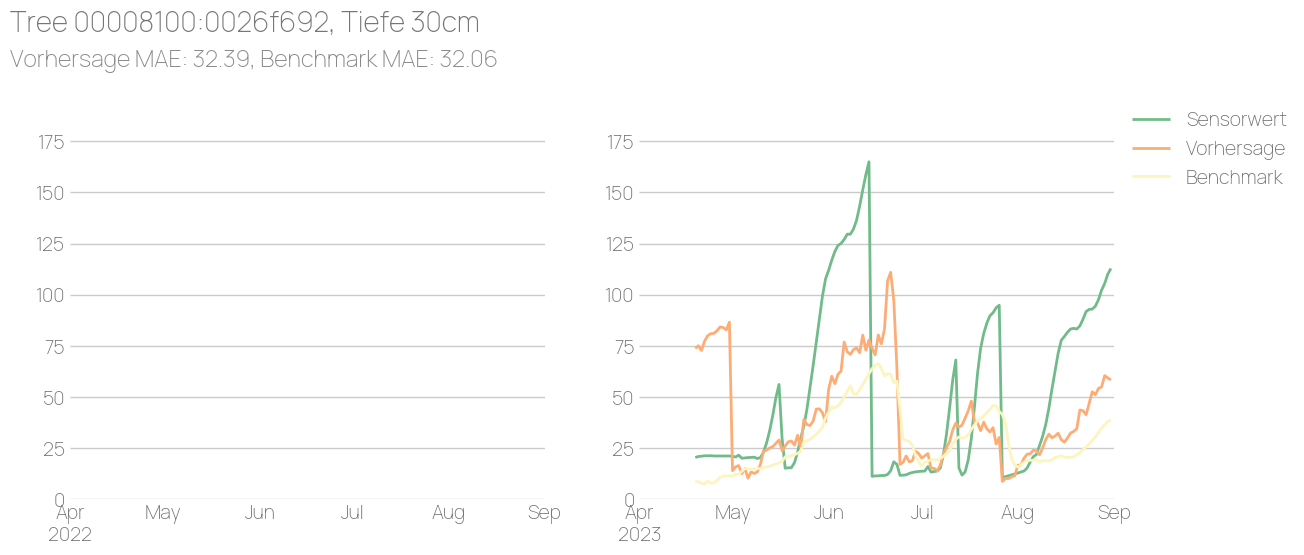

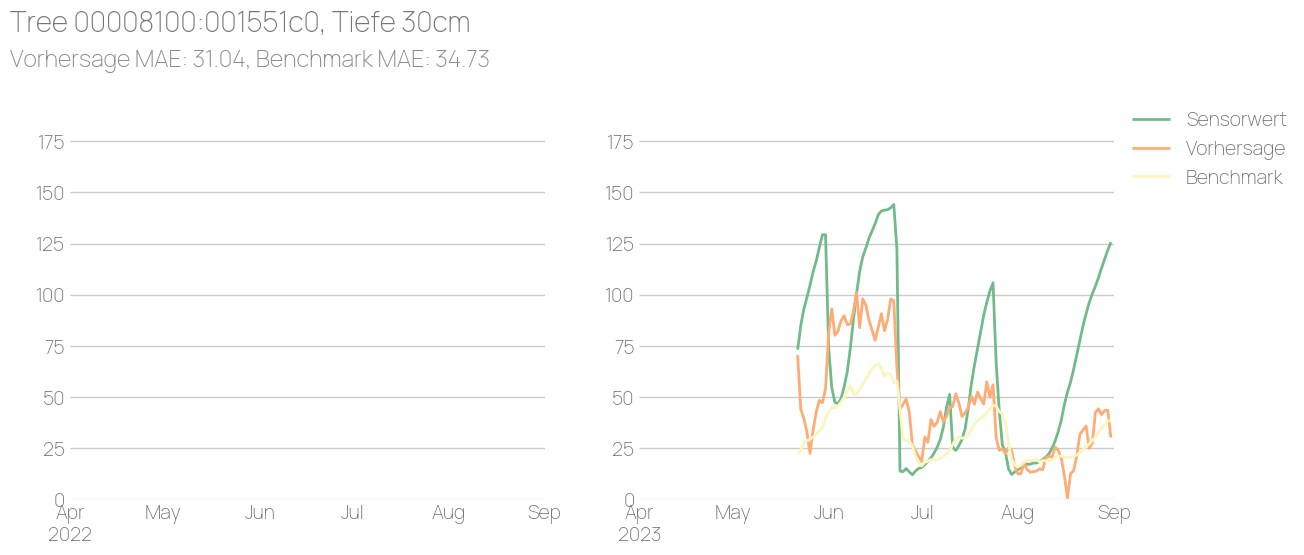

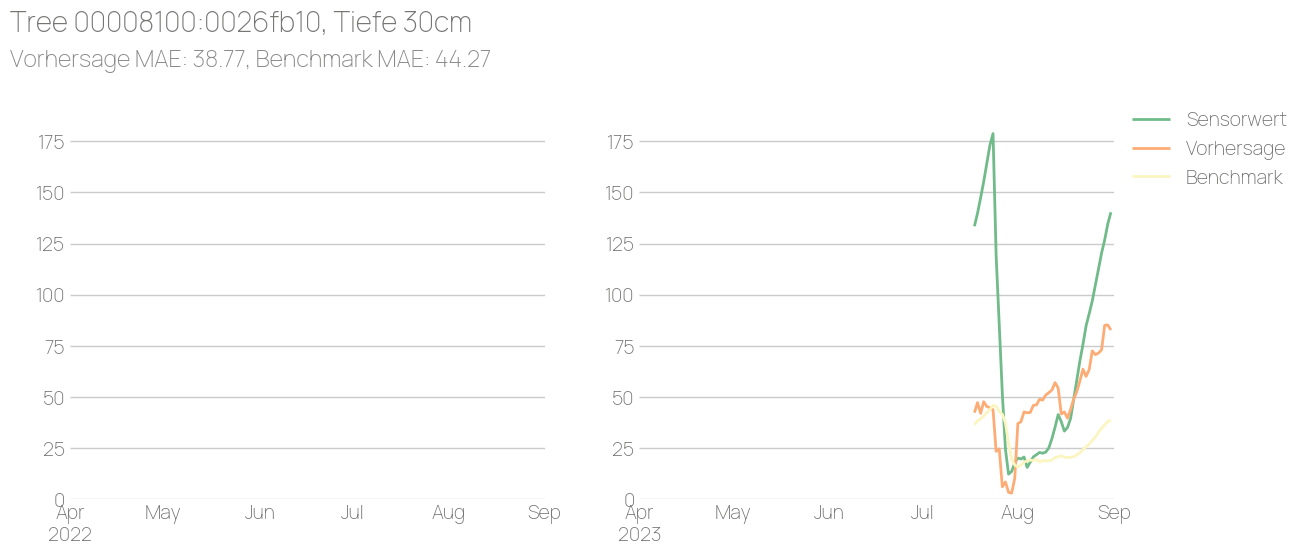

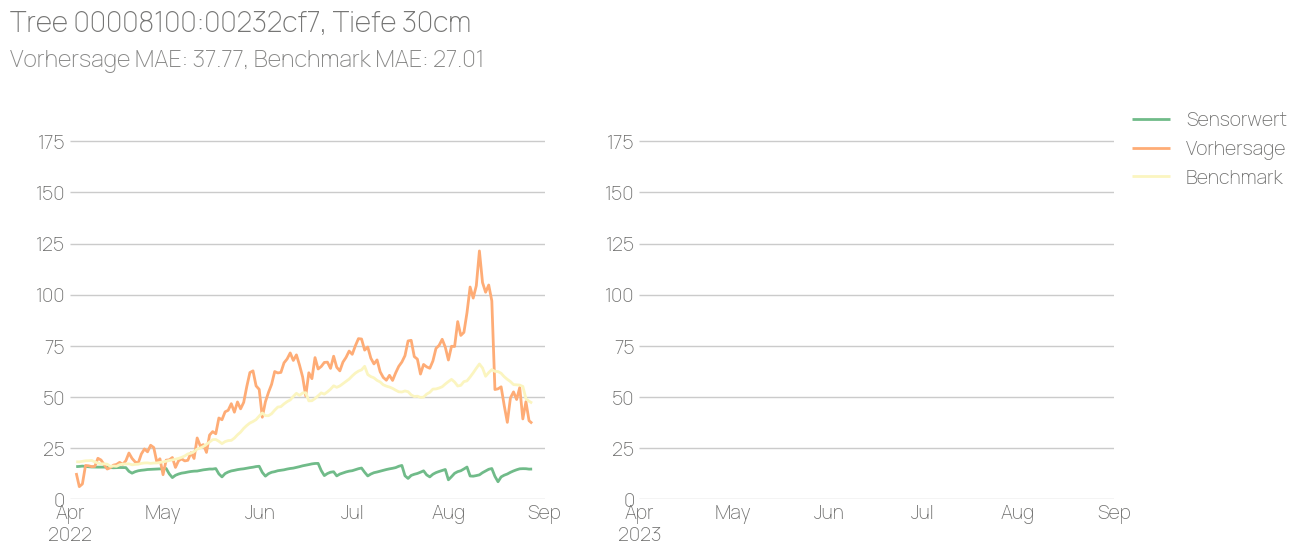

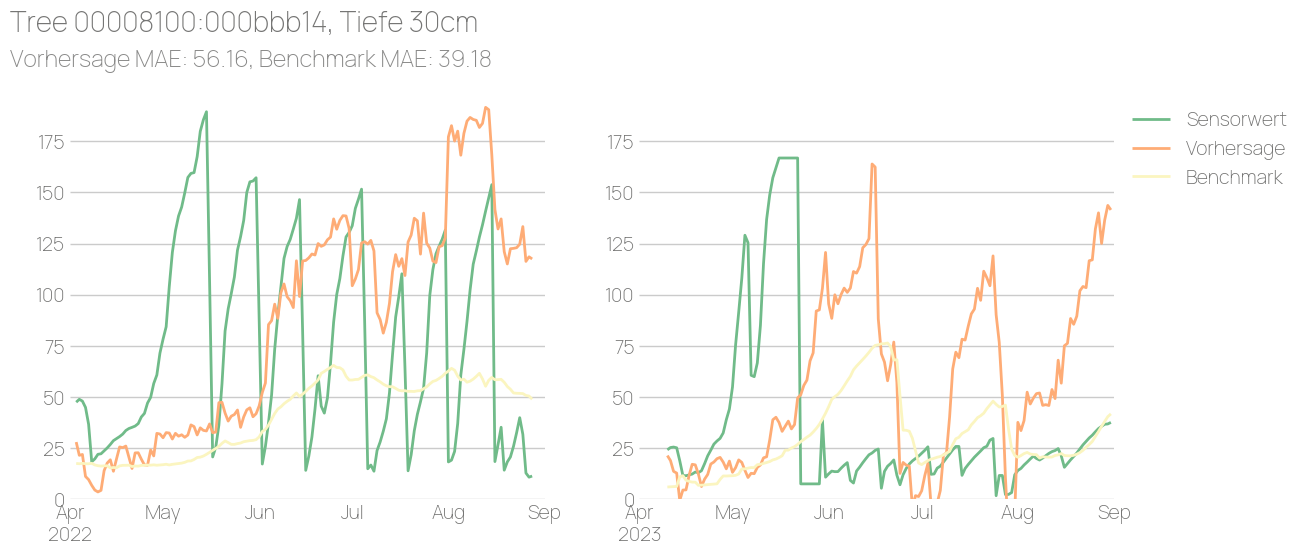

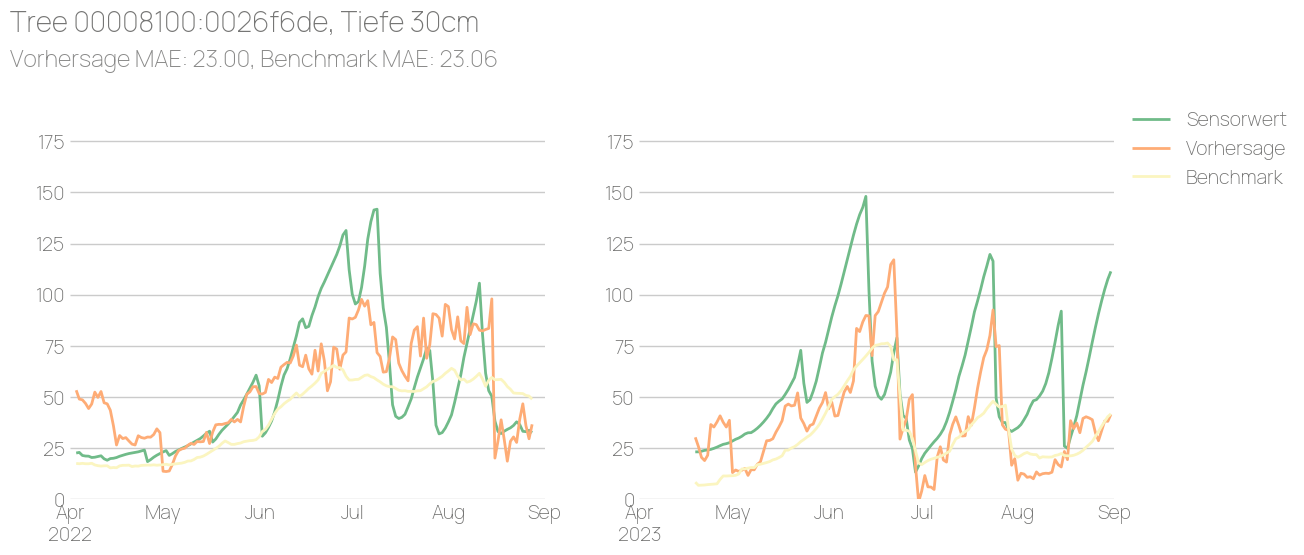

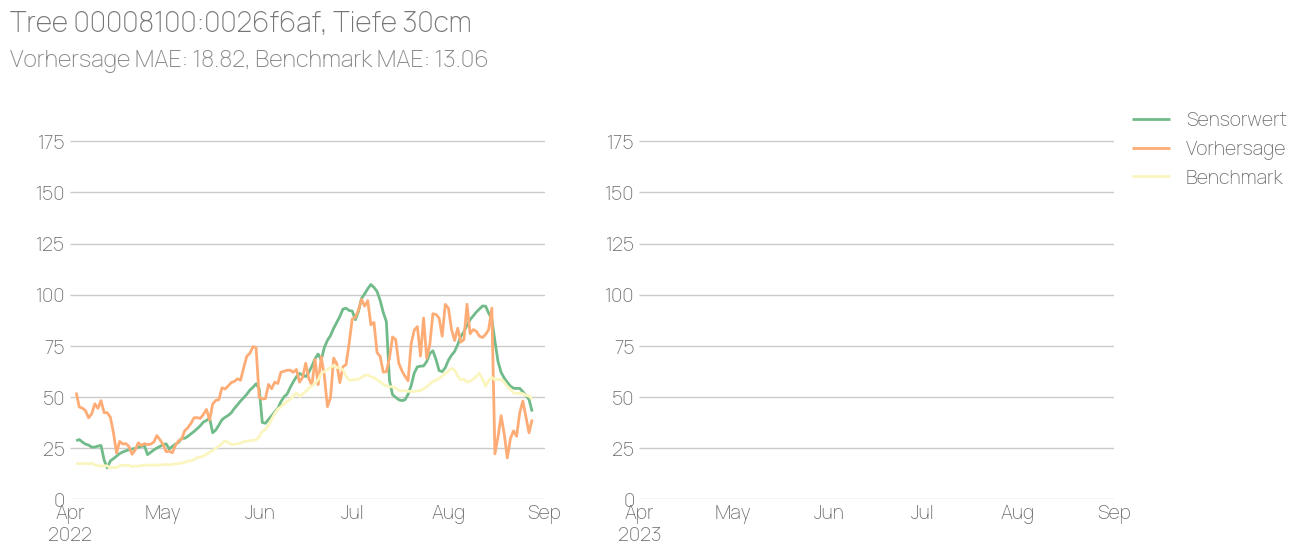

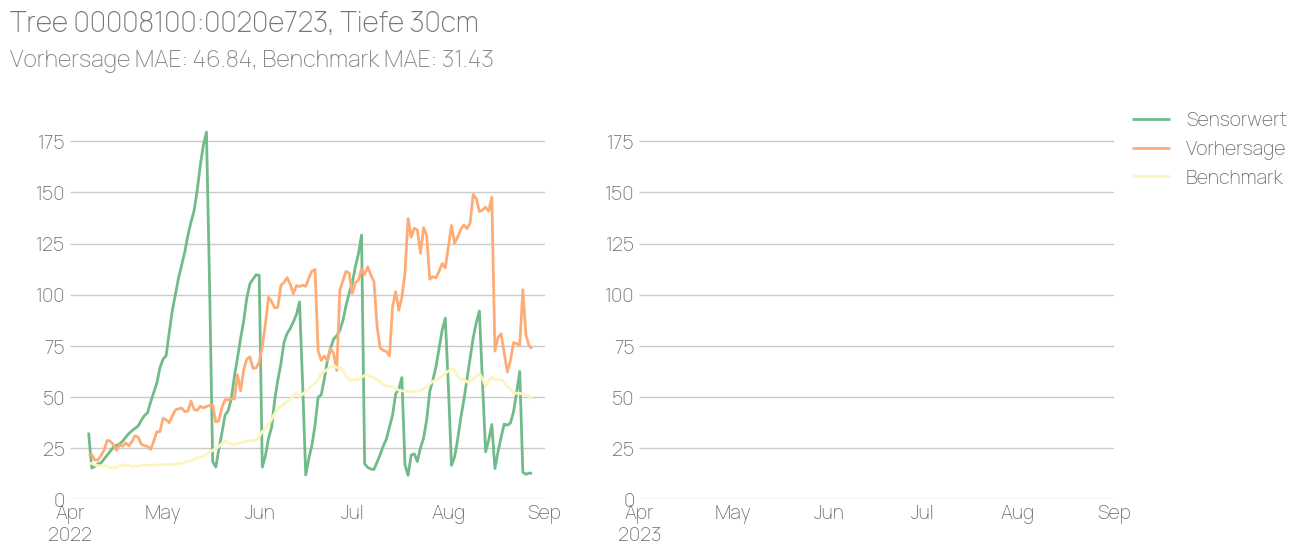

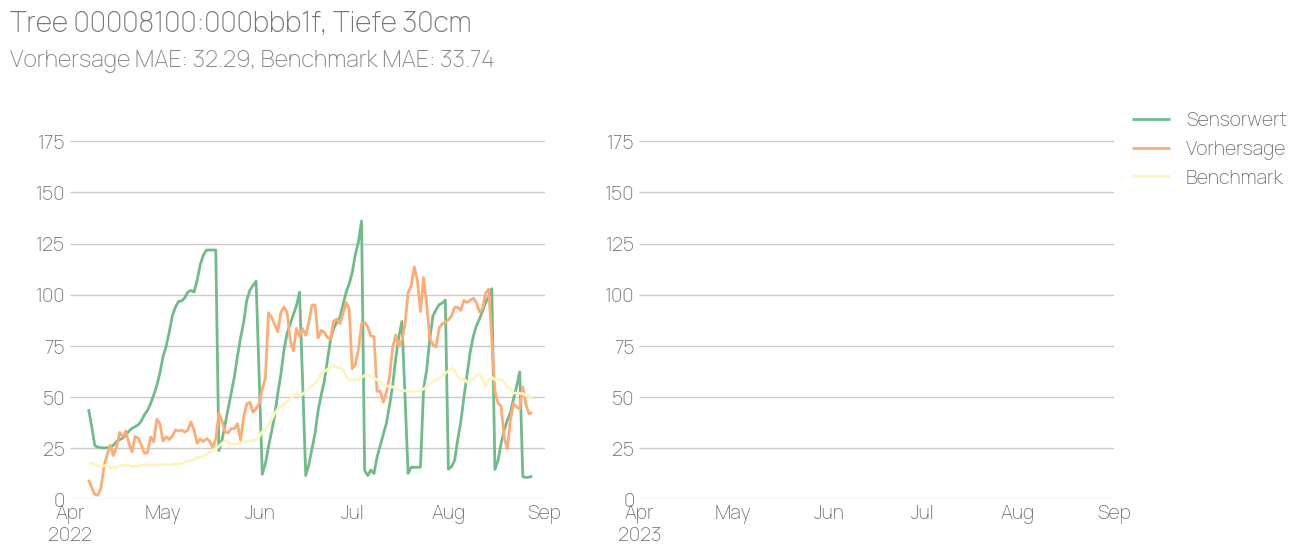

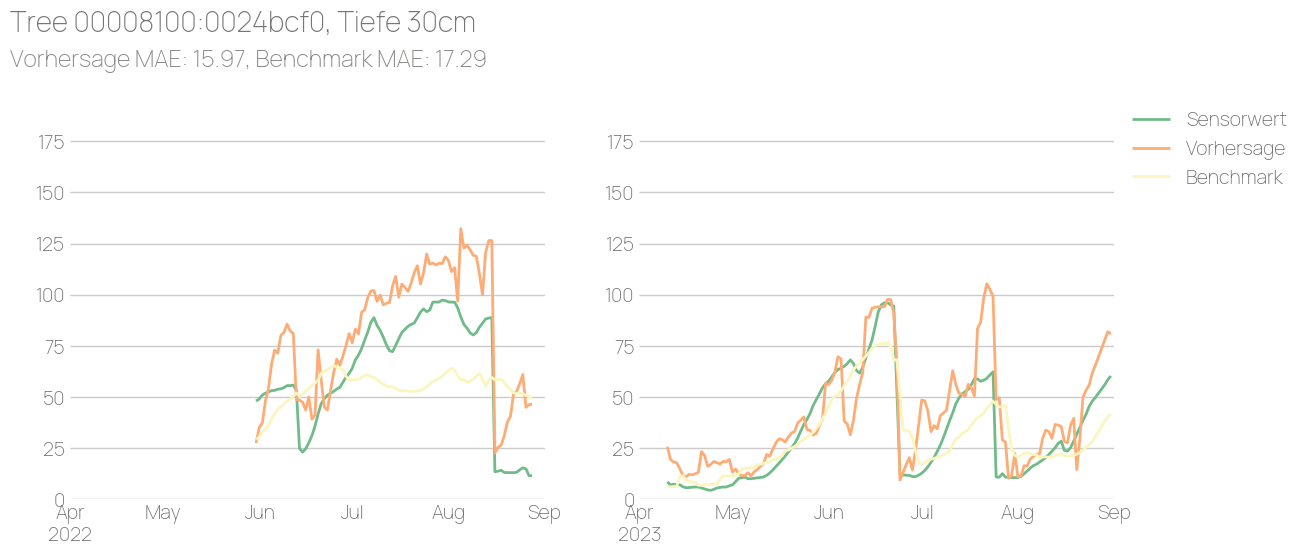

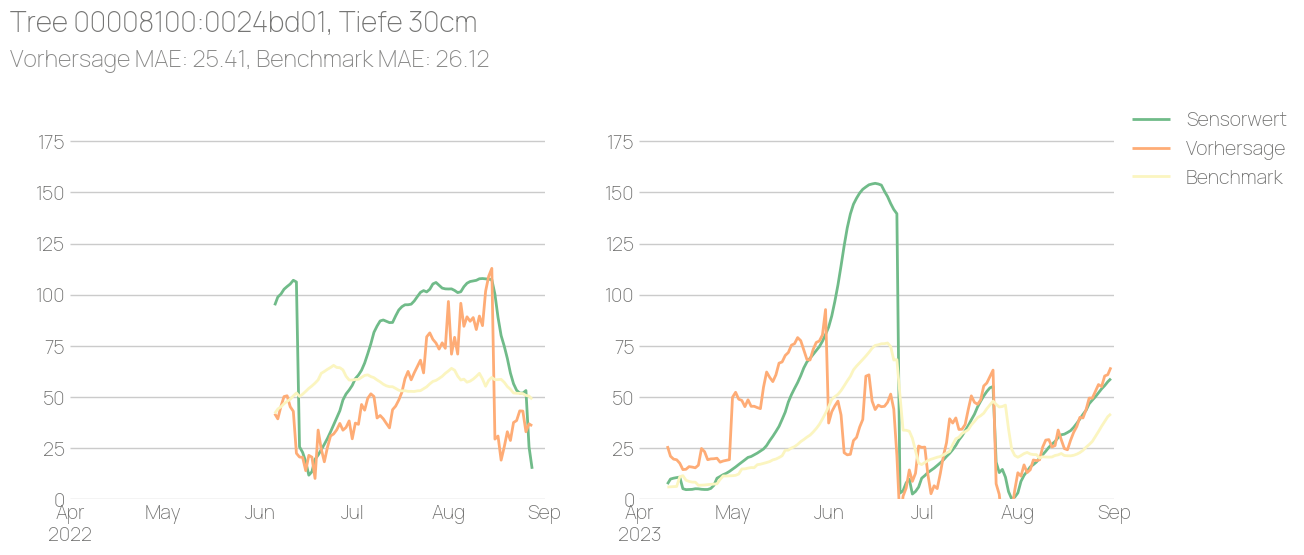

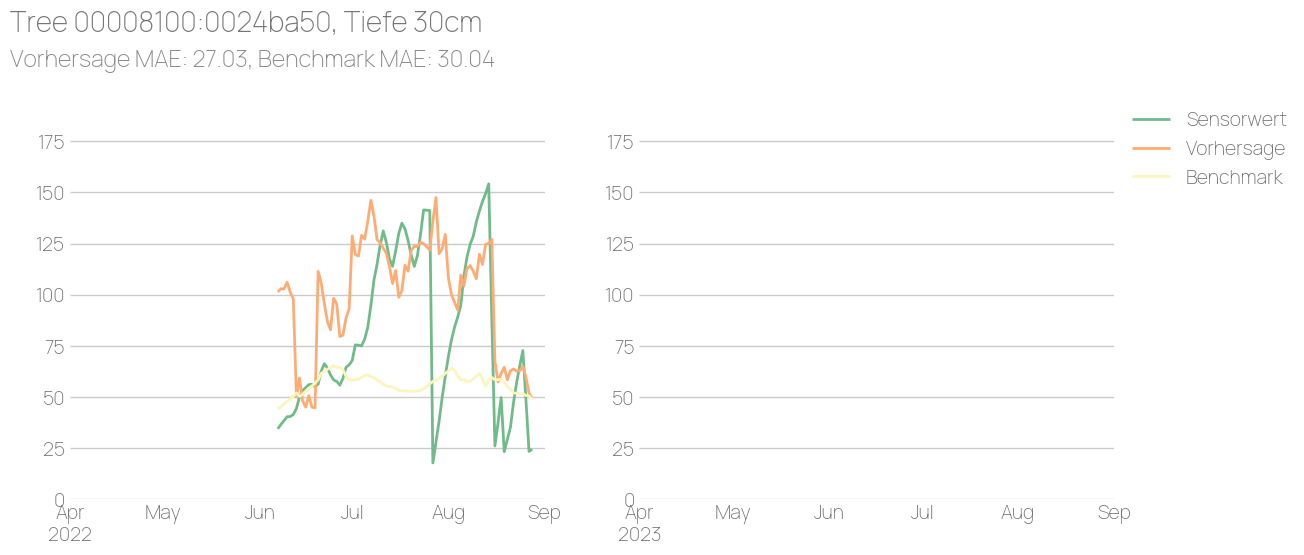

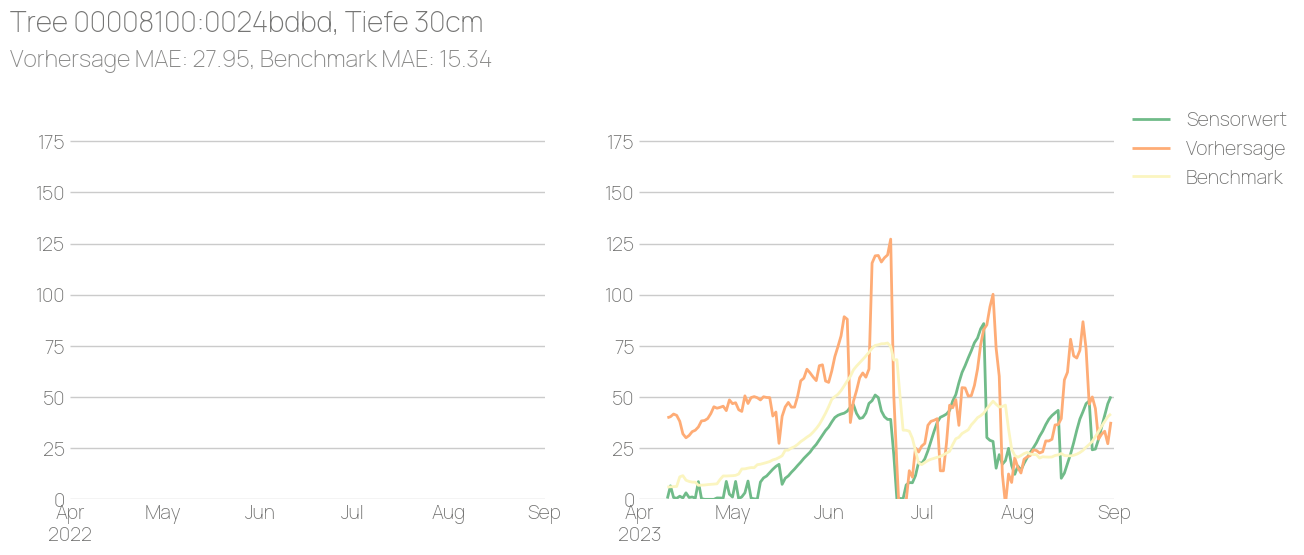

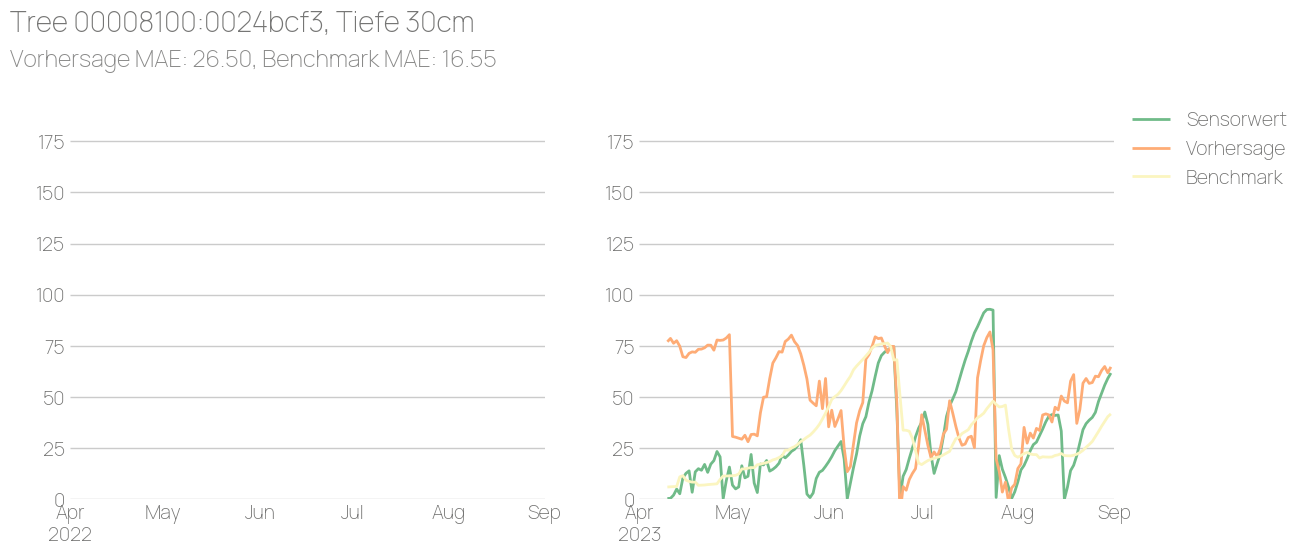

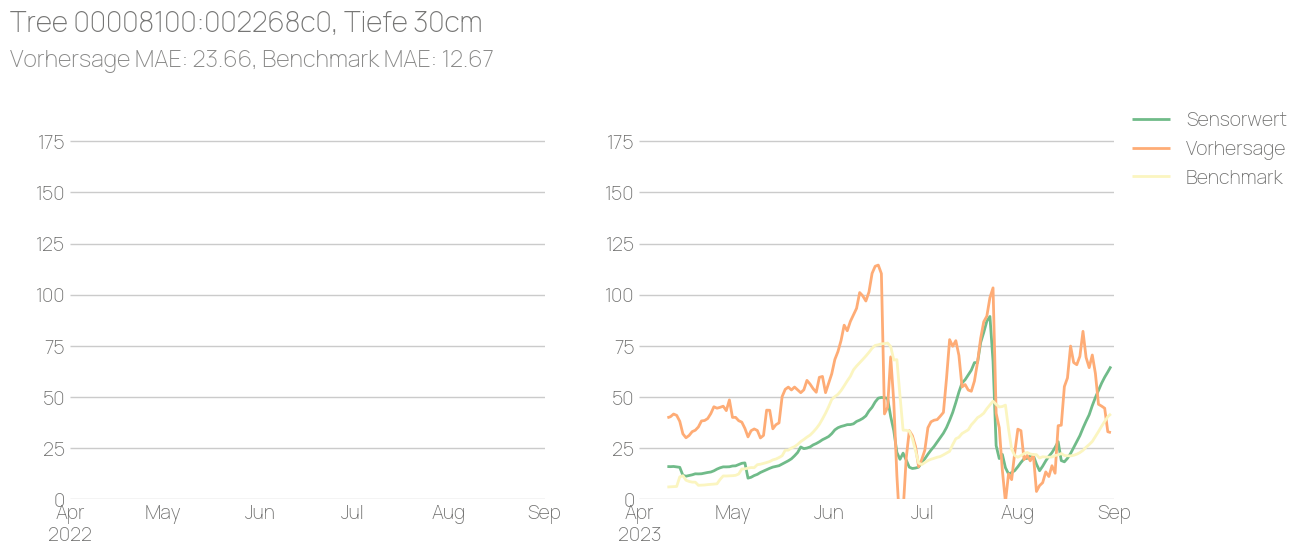

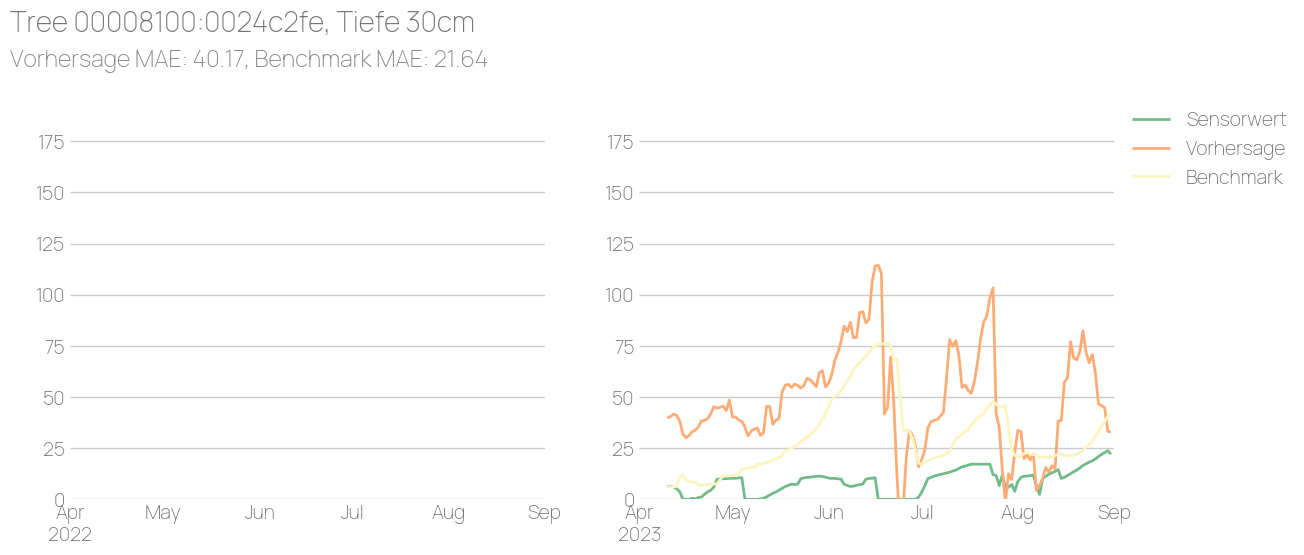

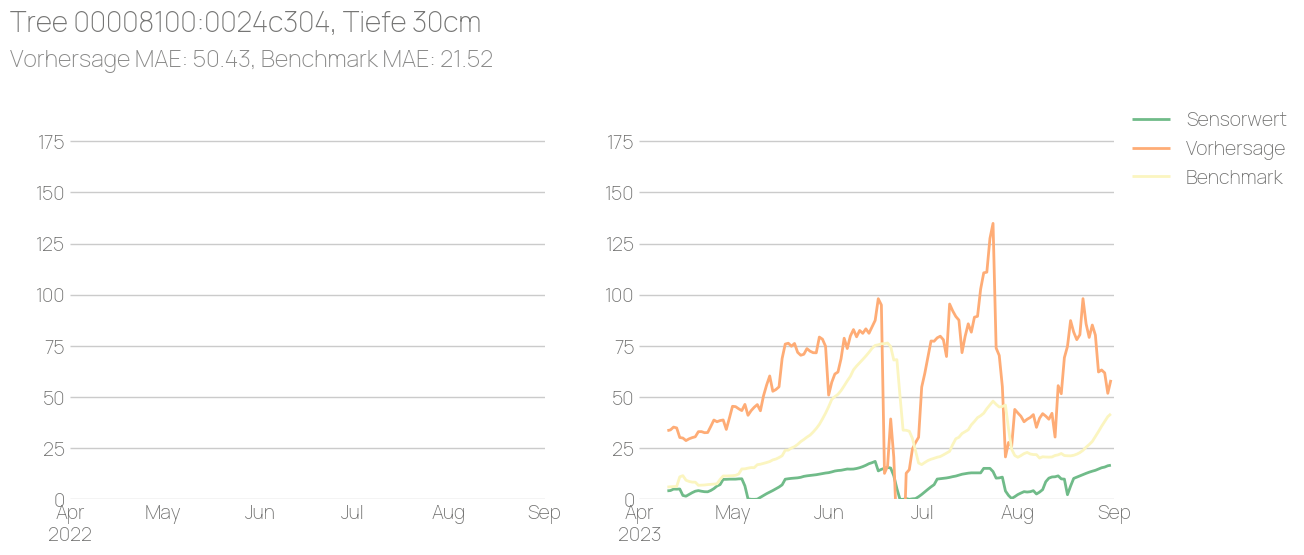

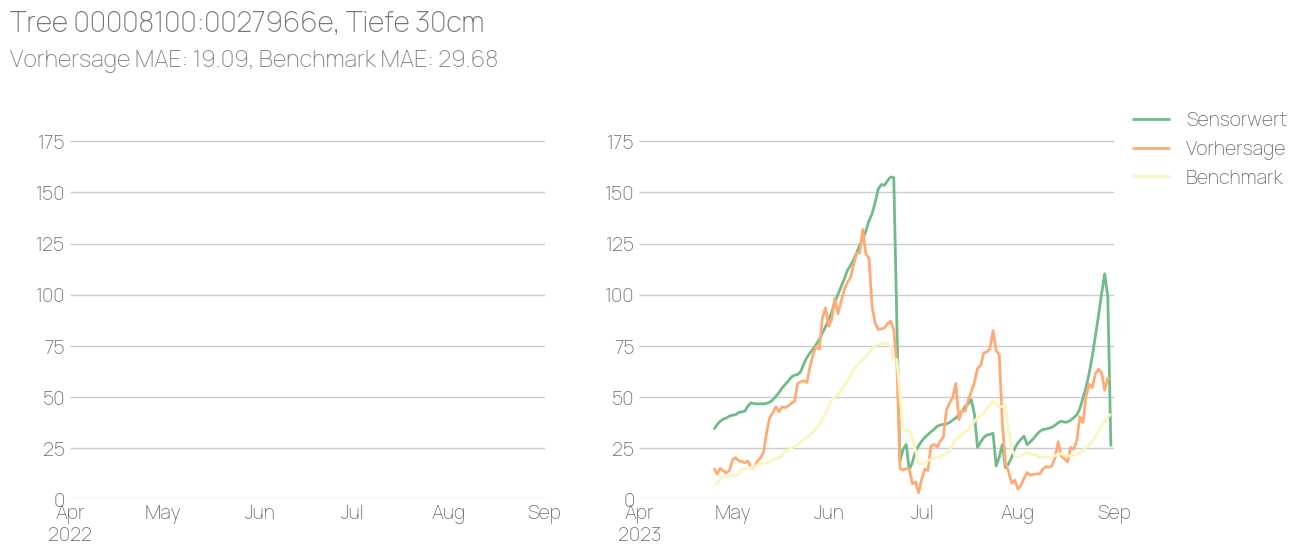

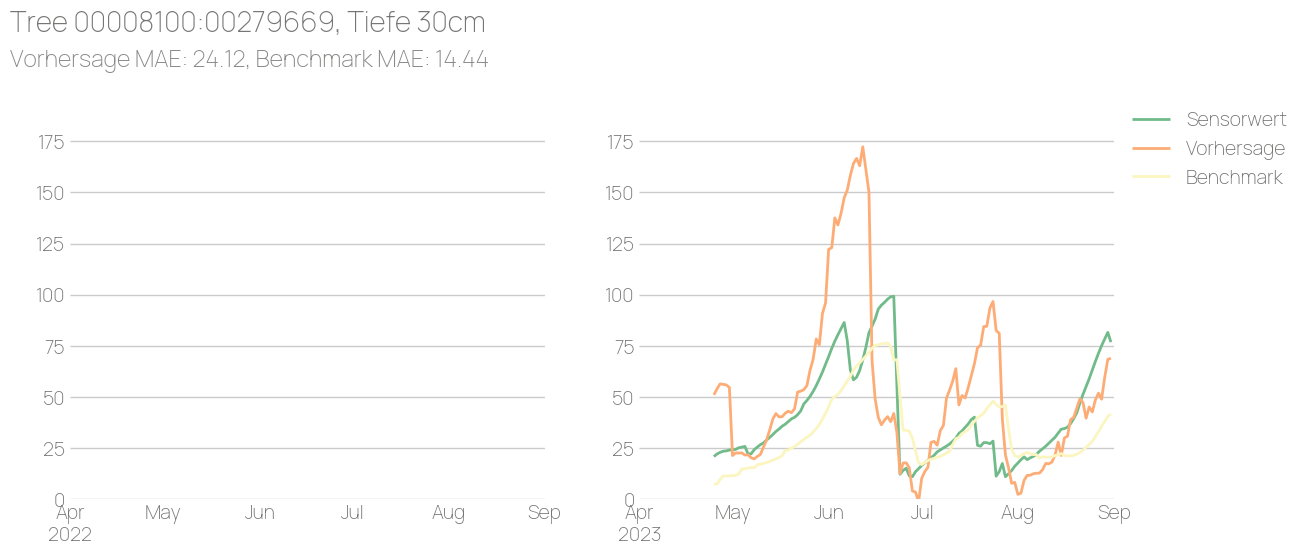

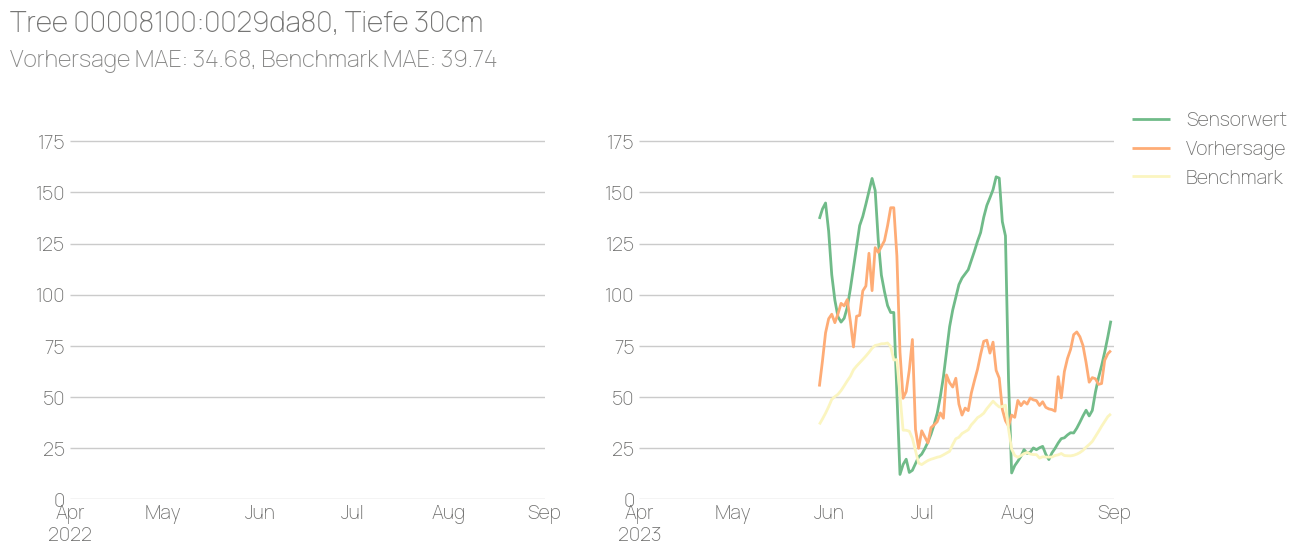

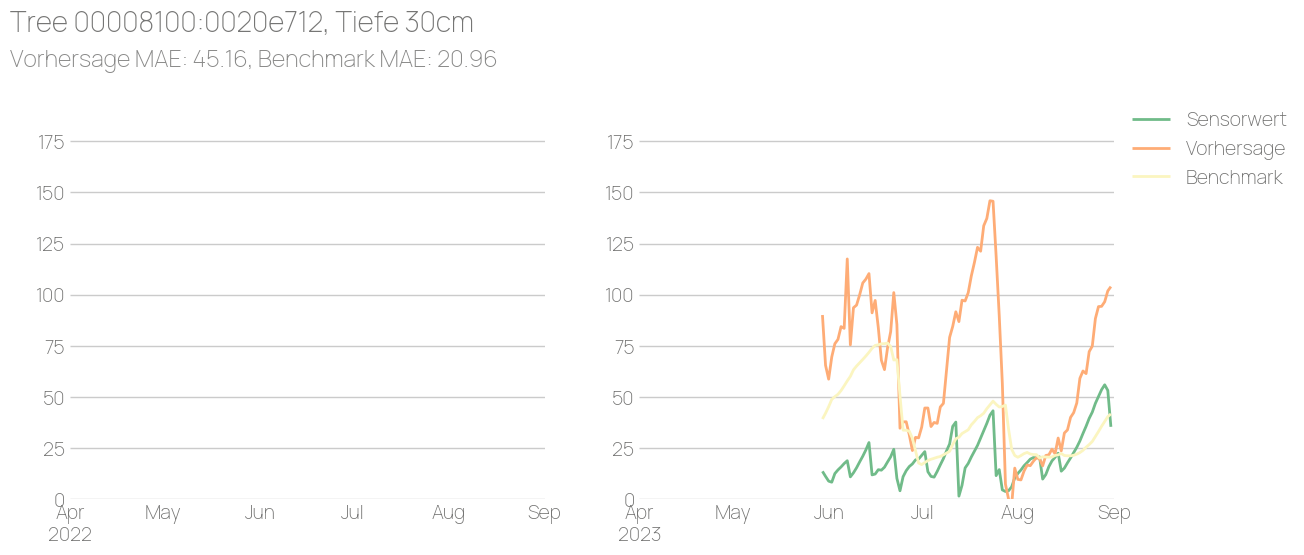

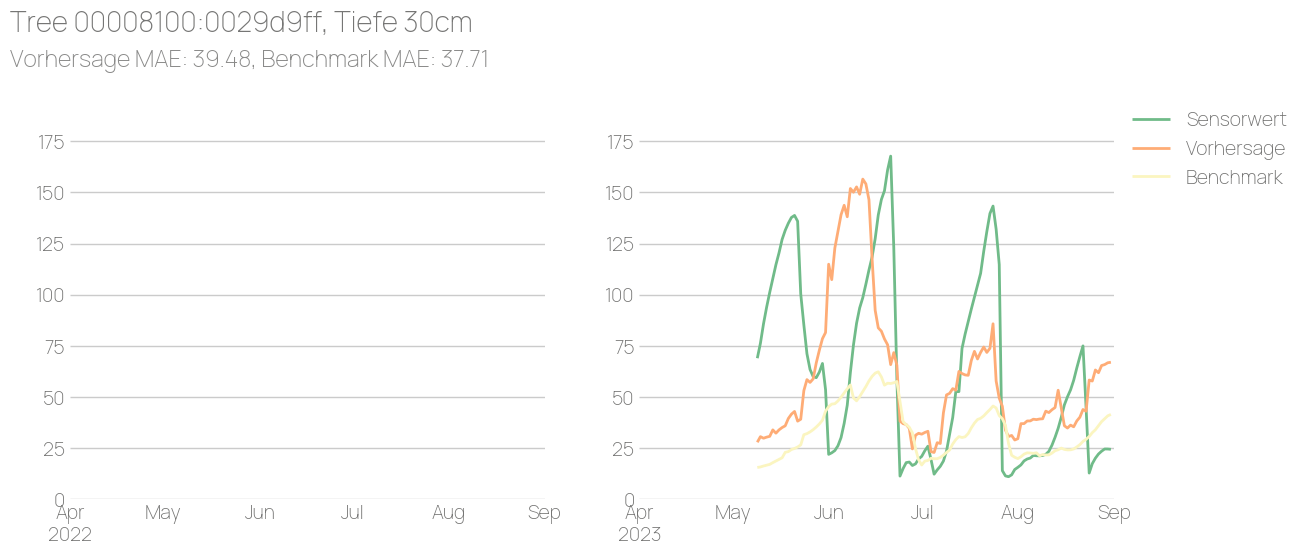

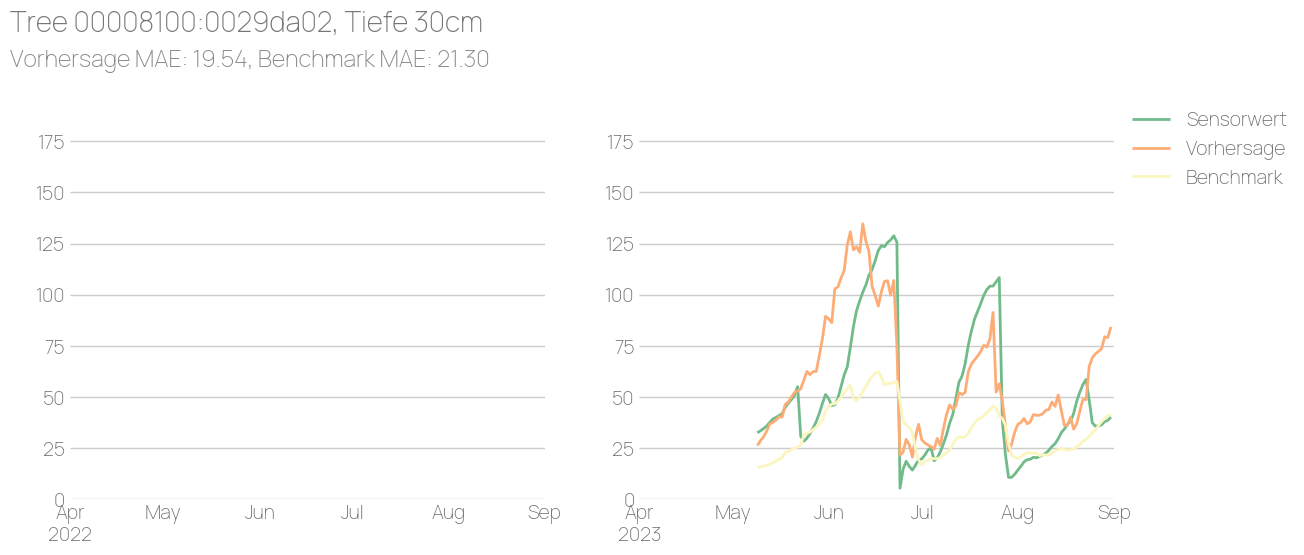

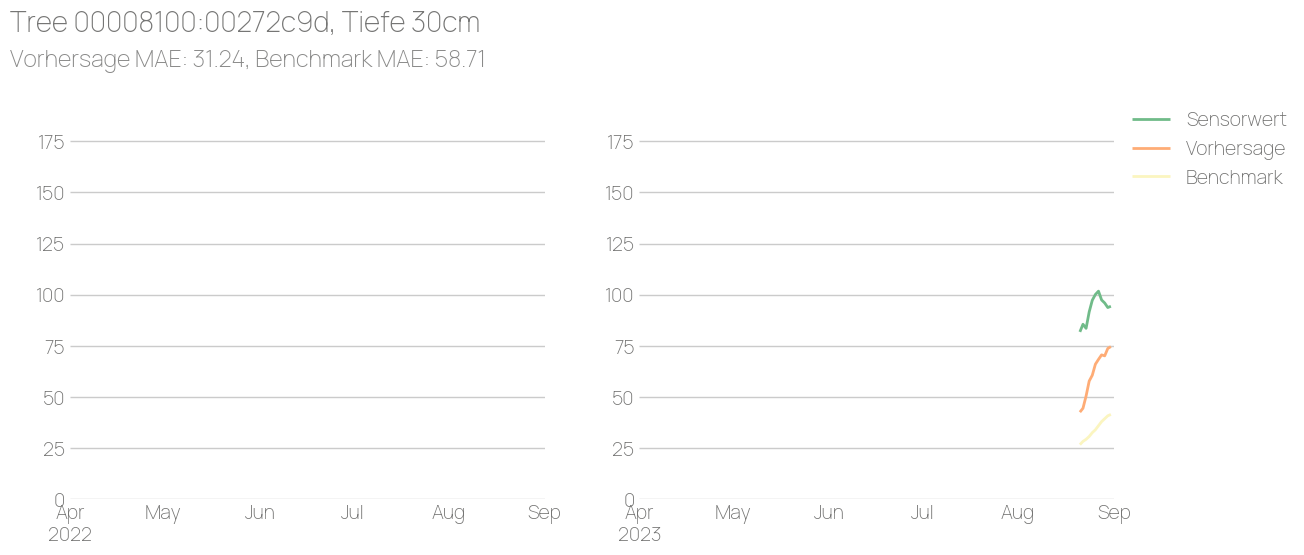

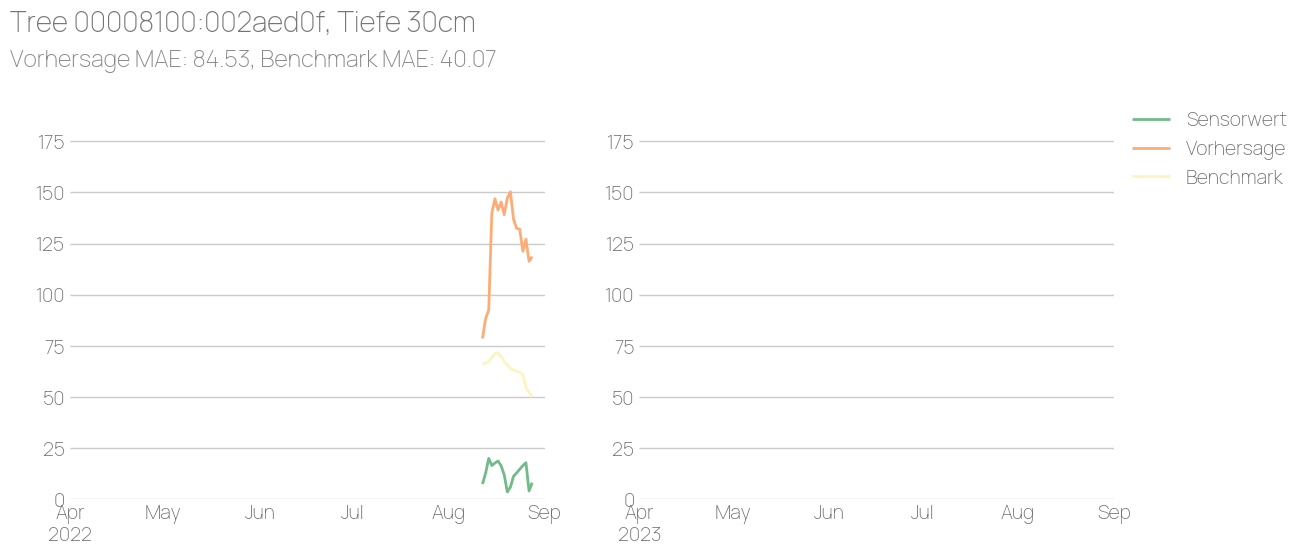

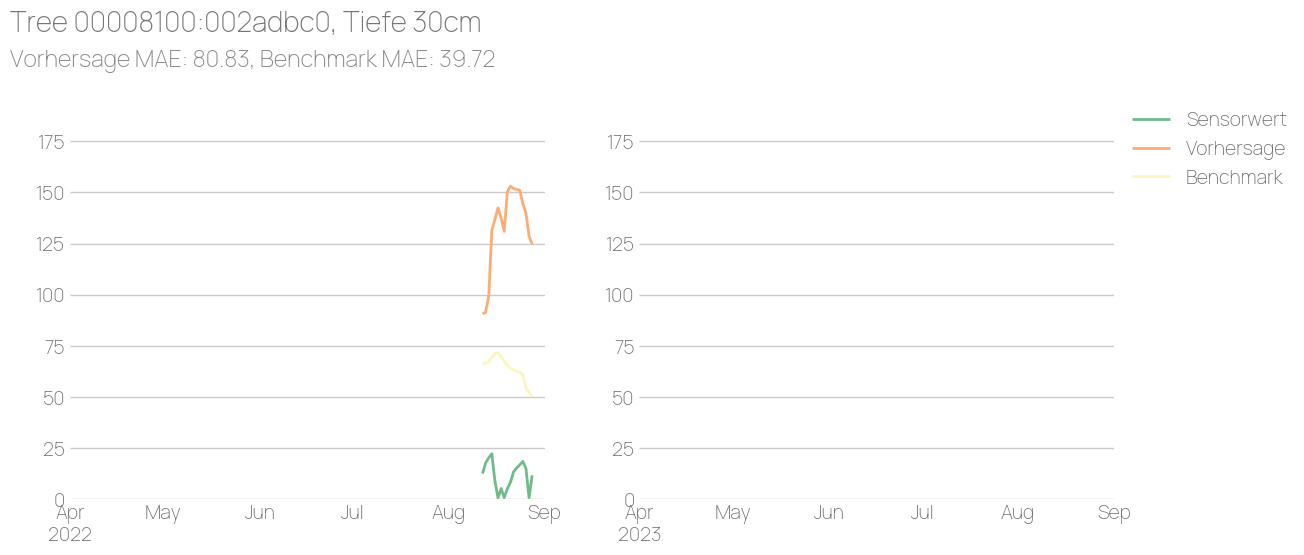

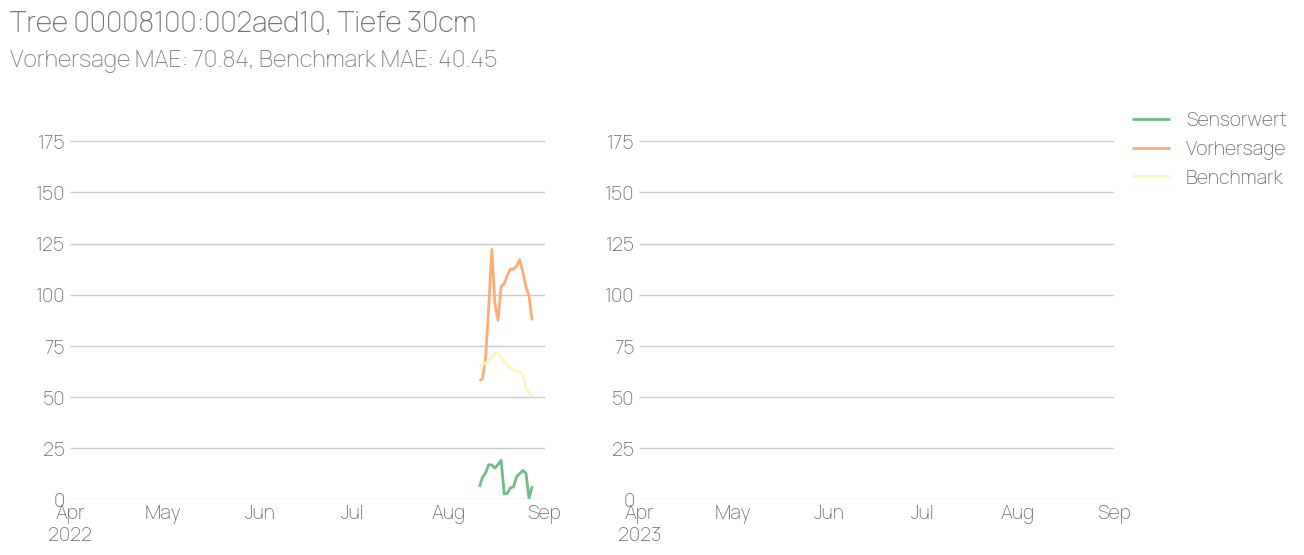

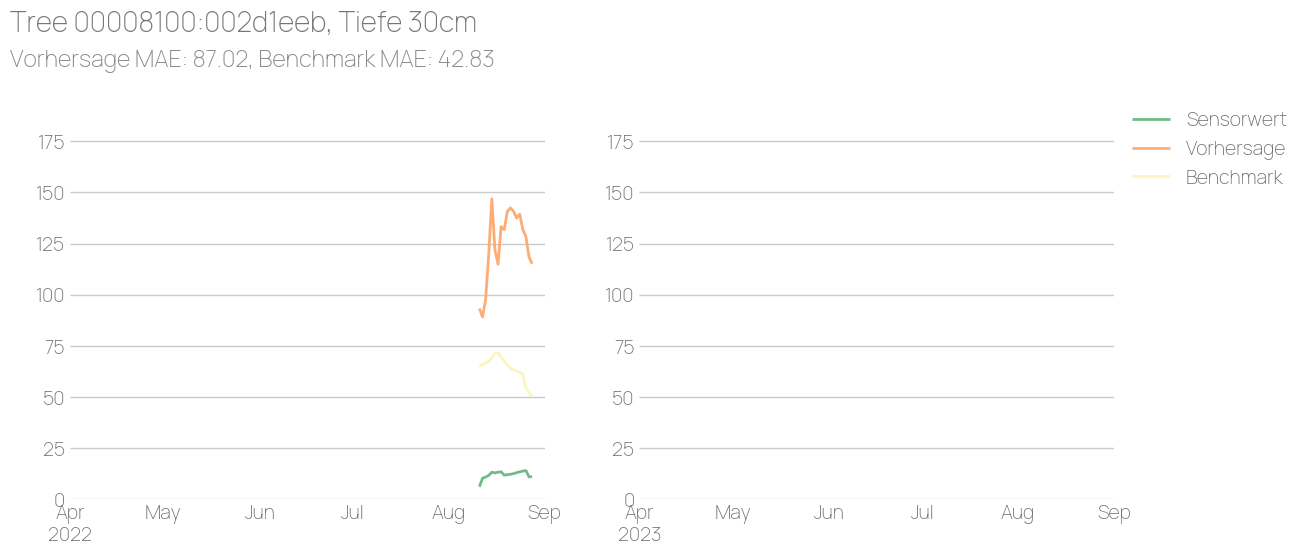

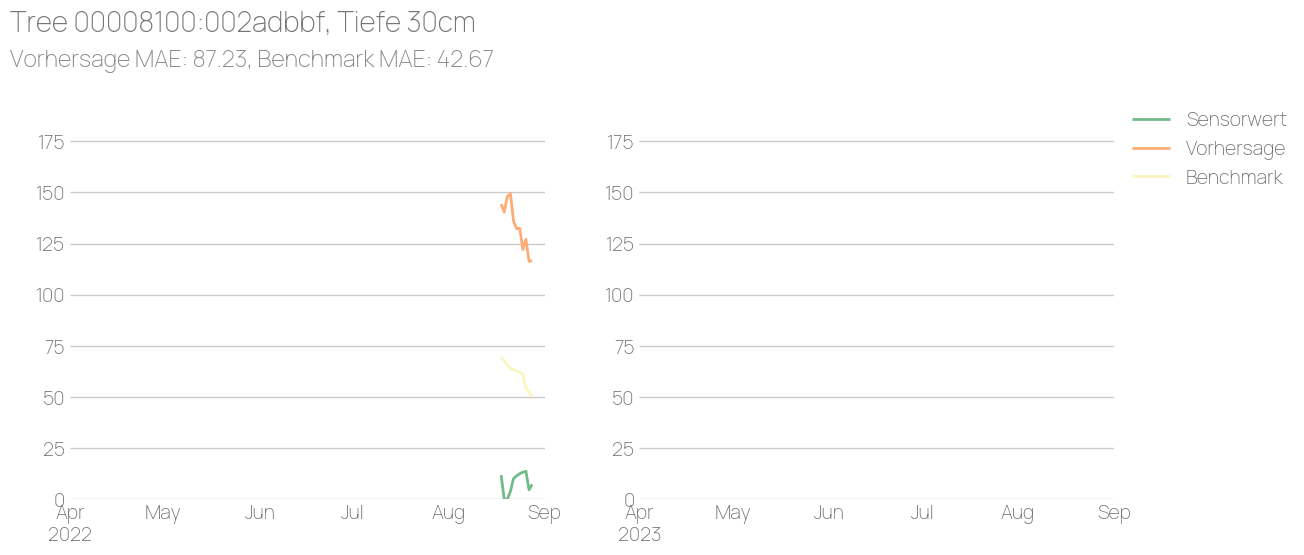

In [188]:
### Things to change
#for md in [2, 3, 4, 5, 8, 13]:
name = f"Slides MVP XGBoost (no rain)" 
features=FEATURES_MVP # FEATURES_POC

#hyper_parameters=dict(max_features="sqrt", n_estimators=1000, max_depth=5, bootstrap=True)
#model = RandomForestRegressor(**hyper_parameters)

# hyper_parameters=dict(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=42, loss="quantile", alpha=.5)
#hyper_parameters=dict(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=42)
#model = GradientBoostingRegressor(**hyper_parameters)

hyper_parameters=dict(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=42)
model = XGBRegressor(**hyper_parameters)

folds = create_train_test_split_across_sites(data, n_splits=4)
results, predictions = evaluate_folds(folds, name, model, hyper_parameters=hyper_parameters, features=features)

#results = evaluate_benchmark_on_folds(folds, log_experiment=True)

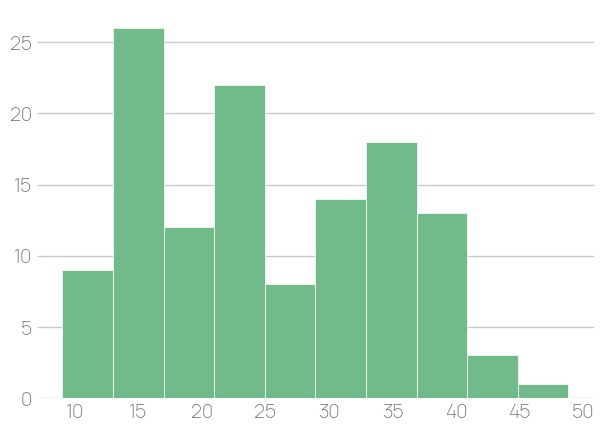

In [184]:
predictions["errors"] = predictions["value"] - predictions["y_hat"] 
predictions["absolute_errors"] = abs(predictions["value"] - predictions["y_hat"])

aggregate_stats = predictions.groupby(["tree_id", "type_id"]).mean().reset_index().sort_values("absolute_errors")

aggregate_stats.absolute_errors.hist()
plt.gca().xaxis.grid(False)



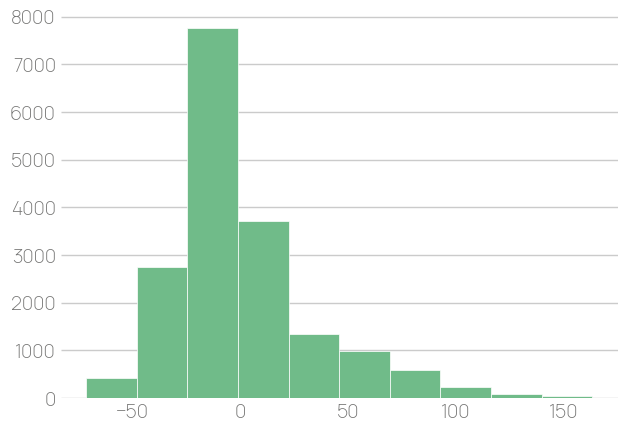

In [185]:
predictions.errors.hist()
plt.gca().xaxis.grid(False)

In [186]:
# find model that is less prone to jiggling
# consider AR featres